# **Data Mining & Machine learning 2020 - Team Nestle**
###Final project of the data mining and machine learning course

- Agon Husejni
- Alberto Molinaro
- Mila Saqipi

##Project - Challenge
Real or Not? NLP with Disaster Tweets: In this project you are challenged to build a Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.

Have you ever wondered if the news were true or not? It is what we are trying to do with our prediction model on tweet related to disasters. Given a set of tweets, we are trying to predict if the messages in the tweets are true or not. We will try to build a model with the best possible accuracy with the data provided.

Here is the summary of our submission with the work accomplished.

##Submissions

For this project, we used AIcrowd (a crowdsourcing platform for code) to submit our predictions. The platform gave us the accuracy score of our model in comparison with the true values. For example, if 80% of our predictions are rights, the accuracy score is going to be 80%.

Submission 1:
- No cleaning
- No testing of models or parameters
- Used TF-IDF
-Model: simple LogisticRegressionCV (without specific parameters)
- Keep it very basic, just to see what we are working with and have our "baseline" 
- **Score: 0.793**

Submission 2:
- Data cleaning - remove unnecessary characters, urls, links etc.
- Used TF-IDF
- Model: LogisticRegressionCV, with (solver = 'lbfgs', max_iter=10000, random_state=72)
- **Score: 0.817**

Submission 3:
- Same as Submission 2
- A little bit of hyperparameter tuning (Cs = 20, cv = 5)
- Concatenated keywords and text
- **Score: 0.819**

Submission 4:
- Advanced data cleaning
- Optimizing parameters with GridSearch
- **Score: 0.82**


Submission 5:
- Optimizing parameters with gridSearch
- Optimizing TF-IDF parameters
- **Score : 0.823 (best one)**

If you want to skip the data cleaning and pre-processing, for avoiding wasting time, go directly to section 4.1 where you can directly load the pre-processed data from the Github repository that we used to build the model.

## **0.Packages**

First of all, we need to install some packages like Pandas, the python data analysis library, Seaborn for statistical data visualization, Sklearn the machine learning library and others.

In [ ]:
!pip install -U autocorrect

In [1]:
# import all necessary packages
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
import spacy
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re 
import string 
import unicodedata
import gensim
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import itertools
from autocorrect import spell, Speller
import base64
import pandas as pd
from IPython.display import HTML
from bs4 import BeautifulSoup

In [ ]:
sp = spacy.load('en_core_web_sm')

This function (create_download_link) allows us to download a csv file where we can find the predictions of the test data after building the model.

In [ ]:
# a special function that will allow us to directly download 
# the file in csv format
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# **1.Data**

Let's explore the data! We load and display both the training and the test data.

In [ ]:
# load the training data
training_data = pd.read_csv("https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/training_data.csv?token=ARFNVHJHVCO5RTK2WCS7QCK7WEVU6")
training_data

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


In [ ]:
# load test data
test_data = pd.read_csv("https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/test_data.csv?token=ARFNVHMJZM7ZIGG4YWRGD6K7WEVWW")
test_data

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
...,...,...,...,...
1137,3497,derailed,NaN,@ItsQueenBaby I'm at work it's a bunch of ppl ...
1138,9191,suicide%20bomber,NaN,#?? #?? #??? #??? Suicide bomber kills 15 in S...
1139,10217,volcano,NaN,Eruption of Indonesian volcano sparks transpor...
1140,5308,fear,New York,Never let fear get in the way of achieving you...


Let's describe a bit of the data beginning with the training set. The training set contains 5 columns (dimensionality) and 6471 objects (numerosity). The five columns are the following: 


*   The id of the tweet
*   The keyword associated with the tweet
*   The location of the tweet
*   The text of the tweet
*   And finally the target (1 if the tweet is true, 0 otherwise)

The test set is composed of the same columns but obviously don't contain the target column. The test set contains 4 columns (dimensionality) and 1142 objects (numerosity).




# **2.EDA**

In [ ]:
# some information about the data
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


We can see some missing value in the dataframes and sometimes some strange characters. Let's see how many missing values there are in the training set and explore a little what types of data there are.

In [ ]:
# most frequent keywords in our training data
training_data.keyword.value_counts()

deluge                   39
earthquake               38
collision                37
harm                     37
fatalities               36
                         ..
forest%20fire            18
epicentre                10
threat                   10
radiation%20emergency     9
inundation                6
Name: keyword, Length: 221, dtype: int64

As you can see, there aren't missing values for the id column but for location and keywords there are some. In the two datasets the types of the objects have not to be changed.

In the following code, We are observing the column 'keyword'.

Now that we load the data, let's see what's inside the columns. 

First of all, we think that the column 'keyword' could be usefull for our model this is why we are going to explore what are the most frequent words in this column through this histogram.

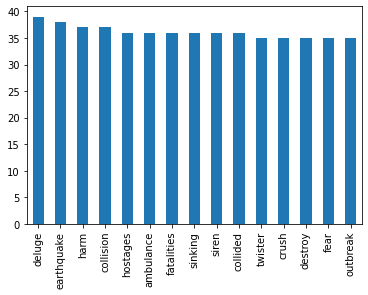

In [ ]:
# bar plot to compare visually the 15 most frequent keywords 
# in our training data
training_data.keyword.value_counts()[:15].plot(kind='bar')

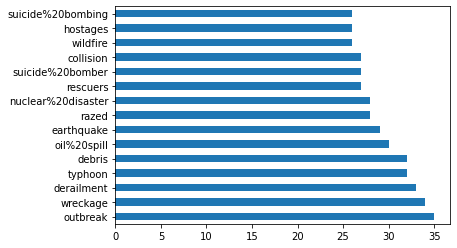

In [ ]:
disaster = training_data[training_data['target'] == 1]
disaster.keyword.value_counts()[:15].plot(kind='barh')

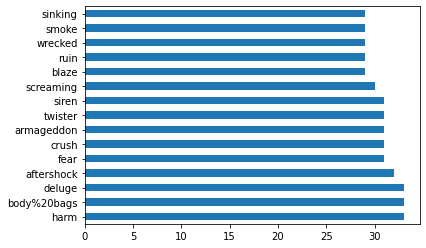

In [ ]:
nondisaster = training_data[training_data['target'] == 0]
nondisaster.keyword.value_counts()[:15].plot(kind='barh')

We can see that most of the keywords are about disasters as we said before and that the keywords associated with the tweets aren't the same if the tweets are true or not.

Let's see how many missing values there are in this columns.

In [ ]:
# See how many nan values we have in total in the keywords column 
# in our training data
training_data.keyword.isna().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

There are 55 missing values in the keyword column in the training dataset and 5 missing values in the test data. As you can see below, we printed how many unique keywords there are in the training set and furthermore, we printed all the keywords to see if there are some mistakes.

In [ ]:
# how many unique keywords do we have in our training data
training_data.keyword.nunique()

221

In [ ]:
# display all unique keywords in our training data
training_data.keyword.unique()

array(['destroyed', 'bioterror', 'windstorm', 'hazardous', 'hostage',
       'landslide', 'trapped', 'weapons', 'burning%20buildings',
       'thunder', 'refugees', 'panicking', 'suicide%20bombing',
       'buildings%20on%20fire', 'seismic', 'bridge%20collapse',
       'emergency', 'body%20bags', 'wounded', 'quarantined',
       'violent%20storm', 'blight', 'destroy', 'detonation', 'ambulance',
       'armageddon', 'military', 'fatal', 'stretcher', 'devastated',
       'thunderstorm', 'hurricane', 'mudslide', 'fatalities', 'razed',
       'ruin', 'hostages', 'bioterrorism', 'cyclone', 'hazard', nan,
       'fear', 'fire%20truck', 'terrorism', 'wreckage', 'fatality',
       'forest%20fire', 'derail', 'fire', 'derailment', 'obliterated',
       'devastation', 'lightning', 'rubble', 'casualties', 'screams',
       'riot', 'wreck', 'bombing', 'wild%20fires', 'nuclear%20disaster',
       'army', 'crash', 'forest%20fires', 'disaster', 'storm', 'hellfire',
       'engulfed', 'blood', 'mass%20

We can see that there are weird characters in the keywords. The space are replaced by '%20' this is why we are going to clean it after that.

The location column didn't improve our model when adding it, this is why we decided to drop it from the analysis. 

For visualizing the words of the text column, we are going to create a wordcloud of the most frequent word to see if there are differences between the tweets that are false and the tweets that are false.

In [ ]:
# prepare the column which we'll use to display the most frequent words through wordcloud
cloud_words = training_data['keyword']
cloud_words

0                   destroyed
1                   bioterror
2                   windstorm
3                   hazardous
4                     hostage
                ...          
6466               earthquake
6467                   derail
6468                  trapped
6469                  weapons
6470    buildings%20on%20fire
Name: keyword, Length: 6471, dtype: object

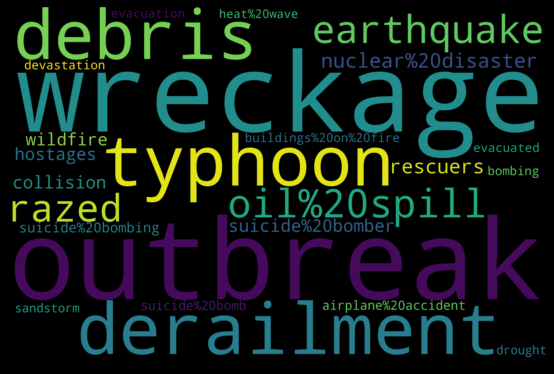

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = None).generate_from_frequencies(disaster.keyword.value_counts()[:25])
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

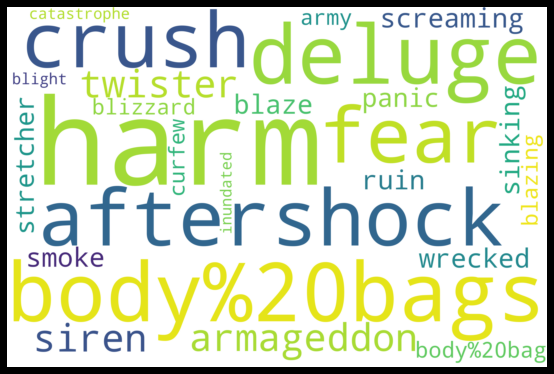

In [ ]:
# Create and generate a word cloud image:
wordcloud_2 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = None).generate_from_frequencies(nondisaster.keyword.value_counts()[:25])
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_2, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Below for visualizing the 'target' column (the column that we are going to predict in the test set), we create an histogram with the count of the two values (1: true tweets, 0: fake tweets). 

We can see that there are more than 3500 fake tweets and more than 2500 true tweets. 

Below the histogram, we calculated the base rate that is equal to 0.57. 57% of the target column is fake news.

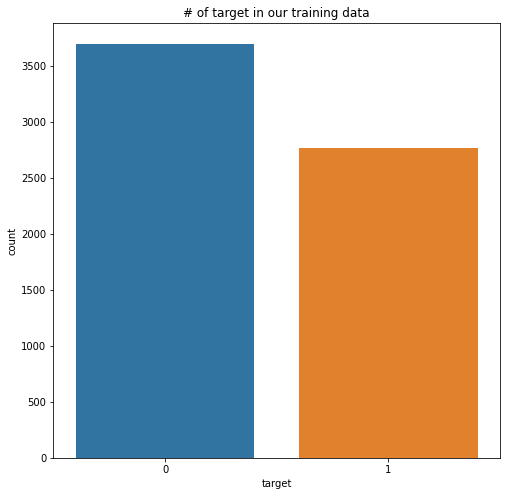

In [ ]:
fig , ax = plt.subplots(figsize=(8,8))
sns.countplot(x='target', data=training_data)
plt.title("# of target in our training data")
plt.show()

In [ ]:
base_rate = training_data.target.value_counts() / training_data.shape[0] 
print(base_rate[0])

0.5719363313243703


In [ ]:
round(training_data.target.value_counts()[0] / len(training_data), 2)

0.57

# **3.Data Cleaning**

Let's clean what we have observed in the EDA section. Remember there were strange characters in the keyword column so the following code is going to clean that:

In [ ]:
training_data.keyword = training_data.keyword.apply(lambda x: str(x).replace('%20', ' '))
test_data.keyword = test_data.keyword.apply(lambda x: str(x).replace('%20', ' '))

Moreover, there were missing values in the keyword column, this is why, trying multiple characters, we observed that the '#' improved the model. We decided to replace the Nan values with this character.

In [ ]:
training_data.keyword.fillna('#', inplace=True)
test_data.keyword.fillna('#', inplace=True)

In previous trials, we saw that too much cleaning would decrease our accuracy score. So, we decide to stop here with the general data cleaning

# **4.Pre-processing**

To better clean the text, in this function (tweet_processing) we tried different things to transform the text: 


*   We put the text in lowercase 
 
*   We standardized words. We observed that, in the tweets, sometimes there are characters like '??????', several same characters one behind the other so we decided to replace all these same characters. Example: 'freeeee' becomes 'free'.   


*   Finally, we tried to deal with smileys.

We decided only to keep the standardized words because it was the only thing that improved the accuracy of our model.


In [ ]:
def tweet_processing(tweet):    
    
    tweet = BeautifulSoup(tweet).get_text()       
    #Lower case
    tweet = tweet.lower()
    
    #CONTRACTIONS 
    '''
    CONTRACTIONS = load_dict_contractions()
    tweet = tweet.replace("’","'")
    words = tweet.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    tweet = " ".join(reformed)
    '''    
    # Standardizing words
    tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    
    #Deal with emoticons 
    #SMILEY = load_dict_smileys()  
    #words = tweet.split()
    #reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    #tweet = " ".join(reformed)
    
    #Deal with emojis
    #tweet = emoji.demojize(tweet)

    #tweet = tweet.replace(":"," ")
    #tweet = ' '.join(tweet.split())

    return tweet

In the following code, we applied the function to the text column of the test and the train data. 

In [ ]:
training_data['text'] = training_data.text.apply(tweet_cleaning)
test_data['text'] = test_data.text.apply(tweet_cleaning)
training_data.text

0       black eye 9: a space battle occurred at star o...
1       #world fedex no longer to transport bioterror ...
2       reality training: train falls off elevated tra...
3       #taiwan grace: expect that large rocks trees m...
4       new isis video: isis threatens to behead croat...
                              ...                        
6466    #earthquake #sismo m 1.9 - 15km e of anchorage...
6467    @emiiliexirwin totally agree.she is 23 and kno...
6468    hollywood movie about trapped miners released ...
6469    friendly reminder that the only country to eve...
6470    buildings are on fire and they have time for a...
Name: text, Length: 6471, dtype: object

The function above (tweet_cleaning) transforms the words like 'Oh my godddd' in 'Oh my godd'. As you can see, there is a mistake in the text cleaned. There is a spelling error. 'Godd' should be written 'God' with only one 'd'. This is why the code below corrects the spelling mistakes in the text column. It corrects also the typos of the tweets.

In [ ]:
# corriger les fautes d'orthographe
speller = Speller(lang='en')
training_data.text = training_data.text.apply(lambda x: " ".join([speller(i) for i in x.split()]))
test_data.text = test_data.text.apply(lambda x: " ".join([speller(i) for i in x.split()]))
training_data

,id,keyword,location,text,target
0,3738,destroyed,USA,black eye 9: a space battle occurred at star o...,0
1,853,bioterror,NaN,#world index no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",reality training: train falls off elevated tra...,1
3,5988,hazardous,USA,#taiwan grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,new isis video: isis threatens to head croatia...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#earthquake #shsmo m 1.9 - 15km e of anchorage...,1
6467,3408,derail,NaN,@emiiliexirwin totally agree.she is 23 and kno...,0
6468,9794,trapped,NaN,hollywood movie about trapped miners released ...,1
6469,10344,weapons,Beirut/Toronto,friendly reminder that the only country to eve...,1


As we saw it in the EDA section, keywords aren't the same if the tweets are true or not. This is why we created the following code that creates a new column with the keywords and the text called "complete " in the training set and in the test set. It is with this column that we are going to build our model.

In [ ]:
training_data['complete'] = (training_data['keyword']+ ' ' + training_data['text']).astype(str)
test_data['complete'] = (test_data['keyword']+ ' ' + test_data['text']).astype(str)
training_data.completer

We observed that there were Nan string text in the 'complete' column this is why we removed it from the column in the following code.

In [ ]:
training_data.complete = training_data['complete'].replace('nan', ' ')
test_data.complete = test_data['complete'].replace('nan', ' ')

In [ ]:
training_data.complete = (training_data.complete).astype(str)
test_data.complete = (test_data.complete).astype(str)

To facilitate the test of our models, we created a file with the clean data so we had not to run all the code above to try different cobinaison of parameters. The code below create a link to download the clean data (train and test set). You can find these datasets on github, they are called train_2 and test_2: https://github.com/amolinar1/DataMiningProject/tree/main/data. 

In [ ]:
create_download_link(training_data)

In [ ]:
create_download_link(test_data)

Some functions we had used for better cleaning (slangs, emoticons). The following function deals with smileys (load_dict_smileys) and the other below deals with English simplifications (load_dict_contractions) that transforms "aren't" in "are not" for example.

Finally, we didn't use these functions for our final predictions because they didn't improve the accuracy of our model. But we still think that if we dug a little, we could have improved the model.

In [ ]:
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

In [ ]:
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

## 4.1 Loading pre-processed data

We load the preprocessed data from the github. Some final features will be cleaned through our spacy tokenizer.

In [ ]:
# import cleaner data from Github instead of going through all the steps again
df_train = pd.read_csv("https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/train_2.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/test_2.csv")

We are going to transform our column 'complete' into tokens. The following two blocks of code contain the affectations and the function (spacy_tokenizer) that allows us to this task. 
The last tasks we perform and prepare before trying the models are :

*   We replaced the following characters '\x92' by the apostrophe "'". We noticed that observing the text column.
*   We remove the tags that didn't add any value at the text analysis
*   We removed the urls, stopwords, numbers and punctuation


In [ ]:
# Define stopwords, punctuation, and numbers
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
numbers = '0123456789'
remove_mentions = '(@[A-Za-z0–9]+)|([⁰-9A-Za-z \t])' 
remove_urls = '(\w+:\/\/\S+)'
# remove_hashtag = '(#[A-Za-z0-9]+)' -> removing hashtags lowered the accuracy

In [ ]:
# Create tokenizer function
def spacy_tokenizer(sentence):

    # Create spacy object
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = [ word for word in mytokens if word not in remove_mentions ]
    mytokens = [ word for word in mytokens if word not in remove_urls ]

    # Some last characters to remove 
    mytokens1 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, '')
      if word != '':
        mytokens1.append(word)

    # Return preprocessed list of tokens
    return mytokens1

# **5.Splitting the data**

To train our model, we are going to define the features (X_train, X_test) and the target column (y_train). We are going to train the model with the newly created column 'complete' made of the 'keyword' and the 'text' in the training set and then, we will be able to predict the values for y_test with different models.

In [ ]:
X_train = df_train["complete"]
X_test = df_test["complete"]
y_train = df_train['target']
X_train

0       destroyed black eye 9: a space battle occurred...
1       bioterror #world index no longer to transport ...
2       windstorm reality training: train falls off el...
3       hazardous #taiwan grace: expect that large roc...
4       hostage new isis video: isis threatens to head...
                              ...                        
6466    earthquake #earthquake #shsmo m 1.9 - 15km e o...
6467    derail @emiiliexirwin totally agree.she is 23 ...
6468    trapped hollywood movie about trapped miners r...
6469    weapons friendly reminder that the only countr...
6470    buildings on fire buildings are on fire and th...
Name: complete, Length: 6471, dtype: object

# **6.Models**

We began with the bag of words. In order to simplify the structure of the notebook, we have decided to keep only the code with which we built the prediction model ie the TF-IDF that provided the best accuracy. We began to fix the parameters of the TF-IDF.

## **6.1 TF-IDF - GridSearchCV**

Now, using  the GridSearchCV function, we are going to find which of the four different classifiers (RandomForest, Knn, LogisticRegression, DecisionTree) is the most fitting one for this type of task that would give us the best accuracy score, so we can focus our further research on only one of them.

## 6.1.1 Big GridSearchCV - Pick the best model & hyperparameters

We first set our TF-IDF vectorizer and tune its hyperparameters that are most fitting to our present pre-processed datasets

In [ ]:
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer, encoding='latin-1', min_df=0.0001, max_df=0.975, ngram_range=(1, 2),  analyzer='word', sublinear_tf=True)

Next we create this dictionnary. It simplifies and puts almost everything necessary in one place. The goal is to use one big GridSearchCV on all of our models, in order to find the best one and the range of its best hyperparameters.

In [ ]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'param_grid' : {
            'classifier__n_estimators': [3,5],
            'classifier__max_features': ['auto', 'sqrt', 'log2']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='lbfgs', max_iter = 10000, n_jobs=2),
        'param_grid': {
            'classifier__C' : np.power(10.0, np.arange(-3, 3)),
            'classifier__multi_class': ['auto']
        }
    },
    'knn' : {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'classifier__n_neighbors': [3,5],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
          
        }
    },
    'dec_tree' : {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__splitter': ['best'],
            'classifier__max_features': ['auto', 'sqrt', 'log2']
        }          
    }
}

The following piece of code is directly linked to the one above. Here we first create an empty list (scores). Then, we extract all the models from above and compute all the possible combinations of the hyperparameters for each model. 

We then make sure that the best combination of hyperparameters for each model is stored in our empty scores list, together with the classifier name and the best score that would come out of it.

Finally, we transform the scores list into a data frame, so it is more conveninent and structured for us to understand it and do the comparisons.

In [ ]:
scores = []

for model_name, mp in model_params.items():
  big_pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', mp['model'])])
  clf =  GridSearchCV(big_pipe, mp['param_grid'], cv=3, 
                      return_train_score=False, 
                      verbose=3)
  clf.fit(X_train, y_train)
  scores.append({
      'model': model_name,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
      })
    
df_models = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_models

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] classifier__max_features=auto, classifier__n_estimators=3 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__max_features=auto, classifier__n_estimators=3, score=0.715, total= 1.1min
[CV] classifier__max_features=auto, classifier__n_estimators=3 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  classifier__max_features=auto, classifier__n_estimators=3, score=0.715, total= 1.1min
[CV] classifier__max_features=auto, classifier__n_estimators=3 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  classifier__max_features=auto, classifier__n_estimators=3, score=0.744, total= 1.1min
[CV] classifier__max_features=auto, classifier__n_estimators=5 .......
[CV]  classifier__max_features=auto, classifier__n_estimators=5, score=0.730, total= 1.1min
[CV] classifier__max_features=auto, classifier__n_estimators=5 .......
[CV]  classifier__max_features=auto, classifier__n_estimators=5, score=0.756, total= 1.1min
[CV] classifier__max_features=auto, classifier__n_estimators=5 .......
[CV]  classifier__max_features=auto, classifier__n_estimators=5, score=0.732, total= 1.1min
[CV] classifier__max_features=sqrt, classifier__n_estimators=3 .......
[CV]  classifier__max_features=sqrt, classifier__n_estimators=3, score=0.720, total= 1.1min
[CV] classifier__max_features=sqrt, classifier__n_estimators=3 .......
[CV]  classifier__max_features=sqrt, classifier__n_estimators=3, score=0.730, total= 1.1min
[CV] classifier__max_features=sqrt, classifier__n_estimators=3 .......
[CV]  classifier__max_

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.4min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] classifier__C=0.001, classifier__multi_class=auto ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__C=0.001, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.001, classifier__multi_class=auto ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  classifier__C=0.001, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.001, classifier__multi_class=auto ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  classifier__C=0.001, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.01, classifier__multi_class=auto ................
[CV]  classifier__C=0.01, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.01, classifier__multi_class=auto ................
[CV]  classifier__C=0.01, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.01, classifier__multi_class=auto ................
[CV]  classifier__C=0.01, classifier__multi_class=auto, score=0.572, total= 1.1min
[CV] classifier__C=0.1, classifier__multi_class=auto .................
[CV]  classifier__C=0.1, classifier__multi_class=auto, score=0.663, total= 1.1min
[CV] classifier__C=0.1, classifier__multi_class=auto .................
[CV]  classifier__C=0.1, classifier__multi_class=auto, score=0.663, total= 1.1min
[CV] classifier__C=0.1, classifier__multi_class=auto .................
[CV]  classifier__C=0.1, classifier__multi_class=auto, score=0.662, total= 1.

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.4min finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, score=0.736, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, score=0.753, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform, score=0.748, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance 
[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance, score=0.736, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance 
[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance, score=0.752, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance 
[CV]  classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance, score=0.750, total= 1.1min
[CV] classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform 
[CV]  classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform, score=0.748, total= 1.1min
[CV] classifier__metric=euclidean, 

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 27.5min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best, score=0.702, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best, score=0.712, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  classifier__criterion=gini, classifier__max_features=auto, classifier__splitter=best, score=0.697, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best 
[CV]  classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best, score=0.677, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best 
[CV]  classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best, score=0.706, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best 
[CV]  classifier__criterion=gini, classifier__max_features=sqrt, classifier__splitter=best, score=0.702, total= 1.1min
[CV] classifier__criterion=gini, classifier__max_features=log2, classifier__splitter=best 
[CV]  classifier__criterion=gini, classifier__max_features=log2, classifier__splitter=best, score=0.690, total= 1.1min
[CV] classifier__criterion=gini, classifi

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.3min finished


,model,best_score,best_params
0,random_forest,0.741153,"{'classifier__max_features': 'sqrt', 'classifi..."
1,logistic_regression,0.792613,"{'classifier__C': 1.0, 'classifier__multi_clas..."
2,knn,0.755370,"{'classifier__metric': 'euclidean', 'classifie..."
3,dec_tree,0.714109,"{'classifier__criterion': 'entropy', 'classifi..."


As you can see on the table above, the model that gave the best accuracy score on the training set is the LogisticRegression. We can also see the range for each hyperparameter, so that we can explore them even further and optimize them. This is why the following GridSearchCV focuses only on this classifier some specific hyperparameters. 


### 6.2 Logistic Regression - GridSearchCV


In the following code, we are going to find the best hyperparameters for this particular data cleaning and with the TF-IDF as we defined it above.

In [ ]:
# After seeing that LogReg is the better and more apporpriate model, 
# we go on to examine it even further in order to find its best hyperparameters

log_reg = LogisticRegression(random_state=72, n_jobs=2, max_iter=5000)

param_grid = [
              {
                  'classifier__penalty' : ['l2'],
               'classifier__C' : np.logspace(-4, 4, 20),
               'classifier__solver' : ['lbfgs'],
               'classifier__multi_class': ['auto']}
              ]

pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', log_reg)])
clf = GridSearchCV(pipe, param_grid, verbose=3)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.2min
[CV] classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.1min
[CV] classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.2min
[CV] classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 
[CV]  classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.1min
[CV] classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 
[CV]  classifier__C=0.0001, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.2min
[CV] classifier__C=0.00026366508987303583, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs 
[CV]  classifier__C=0.00026366508987303583, classifier__multi_class=auto, classifier__penalty=l2, classifier__solver=lbfgs, score=0.572, total= 1.1min
[CV] classifier__C=0.00026366508987303583, classifier__multi_class=auto, classifier__penalty=l2, classifier

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 115.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='latin-1',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.975,
                                                        max_features=None,
                                                        min_df=0.0001,
                                                        ngram_range=(1, 2),
                                        

In [ ]:
sorted(clf.cv_results_.keys())
print(clf.cv_results_)
print('-------')
print(clf.best_estimator_.get_params()['classifier'])
print(clf.best_score_)

{'mean_fit_time': array([55.3454257 , 55.45707951, 55.00864854, 54.86438694, 54.94616156,
       55.28833714, 55.28851848, 55.23160491, 55.28133707, 54.80264382,
       54.88515029, 55.0457664 , 55.5053287 , 55.60127702, 56.15061522,
       55.97474151, 56.42818418, 57.6435739 , 58.07682862, 59.38368025]), 'std_fit_time': array([0.382958  , 0.19404614, 0.38170147, 0.24386991, 0.23592595,
       0.21409725, 0.41997458, 0.1909499 , 0.15635557, 0.55496834,
       0.15802973, 0.35561202, 0.55909254, 0.29155438, 0.46516824,
       0.38058646, 0.46390486, 0.25289162, 0.30738124, 0.60898824]), 'mean_score_time': array([13.65299673, 13.81337132, 13.70836539, 13.64897103, 13.73133664,
       13.77508554, 13.83442006, 13.81866379, 13.73145809, 13.58431439,
       13.61371326, 13.62265878, 13.61536722, 13.66206632, 13.59285355,
       13.61504788, 13.55888009, 13.90276098, 13.72145891, 13.65480614]), 'std_score_time': array([0.13184119, 0.12834308, 0.10038113, 0.10937391, 0.15477976,
       0.190

Here, we can see the best hyperparameters for our classifier, based off of our datasets and tf-idf vectorizers. 

The GridSearchCV allows us to be sure of our hyperparameters. However, we cannot be sure that the datasets are in a perfect state, as it takes the most time and effort to clean and process the data properly. 

We still feel that with these parameters, we get the best score (so far for us)

# **7.Submission**

We found in the code above the best parameters for the LogisticRegression classifier. We are going build the model in the code below.

In [ ]:
# submission based on our final model and parameters found just above
# Fill the XX with the best values we got above

final_classifier = LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=2, penalty='l2',
                   random_state=72, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', final_classifier)])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
pred_2 = pipe.predict(X_train)

In [ ]:
accuracy_score(y_train, pred_2)

0.9324679338587545

As you can see, the training accuracy is 0.932. This means that in 93,2% of the time, our model makes the right predictions for the training set. You can see the confusion matrix in the code below.

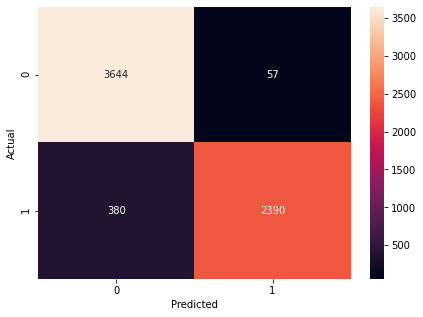

In [ ]:
# Confusion matrix

conf_mat = confusion_matrix(y_train,pred_2)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The confusion matrix shows us that from the training data, it faces the most difficulty when trying to predict the real disaster tweets, as it has wrongly classified 380 out of the total 6'471 in the training data. 

We could examine the reasons for the wrongly classified disaster tweets. What did we not do (process, clean, etc) on the training data that made us misclassify those tweets ?


In [ ]:
submission = pd.DataFrame(pred)
create_download_link(submission)

# **8.Evolution**

To sum up the progress of the work released through the weeks, we have this section with some visualizations of our submissions on AIcrowd that gave us the accuracy of our predictions calculated with the actual true values for y_test that we didn't have access to during the contest.

In [2]:
evolution = pd.read_csv('https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/evolution.csv', sep=',')
evolution.dtypes

Date                        object
accuracy_score             float64
jobs_done                   object
model                       object
parameters                  object
Vectorizer or tokenizer     object
dtype: object

In [4]:
evolution['Date'] = pd.to_datetime(evolution['Date'])
evolution.tail()

,Date,accuracy_score,jobs_done,model,parameters,Vectorizer or tokenizer
21,2020-12-06,0.806,GridSearchCV + a lot of cleaning + PCA,LogisticRegression,"(C=2, max_iter=10000)",TF-IDF - default
22,2020-12-07,0.818,RandomizedSearchCV,LogisticRegression,"(C=3, max_iter=10000)",TF-IDF - default
23,2020-12-08,0.820,Better GridSearchCV,LogisticRegression,"(C=1.0, max_iter=10000, multi_class='ovr')",TF-IDF - default
24,2020-12-09,0.823,Same GridSearchCV + fixing some spelling mista...,LogisticRegression,"(C=2.2357, max_iter=10000)","(min_depth=0.01, max_depth=0.9, n_gram_range=(..."
25,2020-12-10,0.835,Even better GridSearchCV + optimiting TF-IDF p...,LogisticRegression,"(C=1.623776739188721, class_weight=None, dual=...","(tokenizer=spacy_tokenizer, encoding='latin-1'..."


(0.75, 0.85)

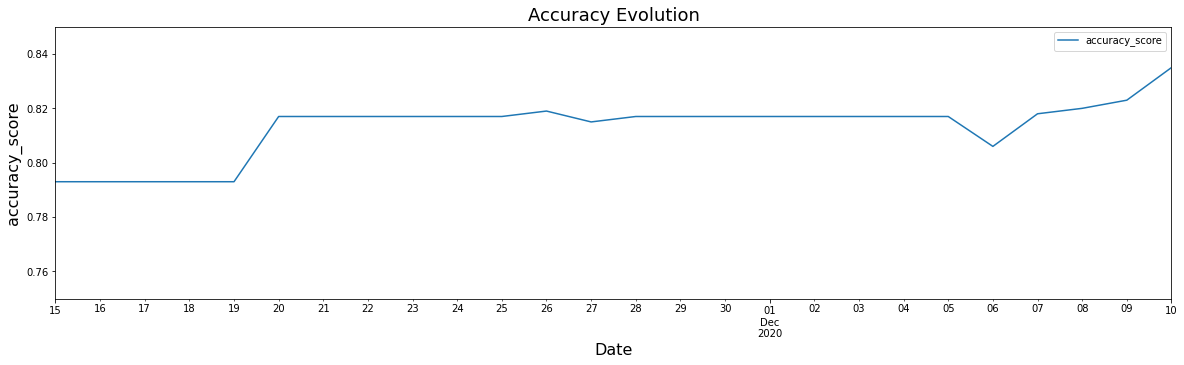

In [ ]:
evolution.plot(kind='line', x= 'Date', y='accuracy_score', figsize=(20,5))
plt.xlabel('Date', size=16)
plt.ylabel('accuracy_score', size = 16)
plt.title('Accuracy Evolution', size = 18)
axes = plt.gca()
axes.set_ylim([0.75,0.85])

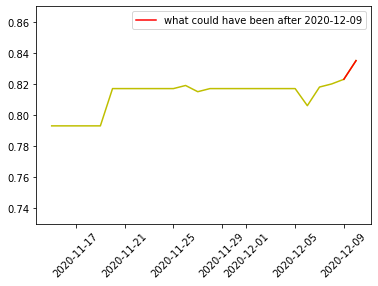

<Figure size 3600x3600 with 0 Axes>

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/amolinar1/DataMiningProject/main/data/evolution.csv", sep=',')
df1.Date = pd.to_datetime(df1.Date, format = '%Y-%m-%d')
df1.accuracy_score = pd.to_numeric(df1.accuracy_score)
#best score cutoff date
cutoff = "2020-12-09"
#sort dataframe because unsorted dates will not plot properly
df1 = df1.sort_values(["Date"])
#plot the whole dataframe in yellow
plt.plot(df1.Date, df1.accuracy_score, c = "y")
#plot the conditional data on top in red
plt.plot(df1[df1.Date >= cutoff].Date, df1[df1.Date >= cutoff].accuracy_score, c = "r", label = "what could have been after {}".format(cutoff))
plt.xticks(rotation = 45)
plt.legend()
axes = plt.gca()
axes.set_ylim([0.73,0.87])
plt.figure(figsize=(50,50))
plt.show()

The best accuracy score that we obtained with the test data was 0.823. We think that we could have improved the model if there were more submissions available. Hence the red piece of the curve that ascends after the last week. Of course this is just an assumption, but we are very confident that this would be the case, because of the experience and the deeper understanding we have of the project, datasets and classifiers. Nonetheless, we are satisfied with the results and the improvements of the model through the weeks. We enjoyed the project and its challenges very much.

#**9.Next time...**

To conclude, this block of code is a GridSearch that would give us the best parameters for the TF-IDF and the logistic regression in order to optimize the accuracy of the model. The limitation of resources did not allow us to run this code. Indeed, it would have taken around too much time (days) to get the outputs. So if you're trying to run that last block of code, be patient.

In [ ]:
# if we had had a lot of time and a super PC, with a GridSearchCV similar to this one
# we'd have found all hyperparameters necessary (so we think and assume)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer,stop_words=stop_words)),
    ('clf', LogisticRegression(max_iter=10000, random_state=777))
])
parameters = {
    'tfidf__max_df': (0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99),
    'tfidf__min_df':(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3), (3,3)],
    'tfidf__encoding': ['uft-8', 'latin-1'],
    'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['lbfgs'],
    'classifier__multi_class': ['auto']}
              ]
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

This GridSearchCV would remove our doubts concerning the hyperparameters of TF-IDF AND our classifier. In  our work we were able to optimize the hyperparameters for our classifier. But we were unsure if the hyperparameters of TF-IDF that we utilised to find those optimum classifier hyperparameters, were also optimized. This GridSearchCV would make sure that both the classifier (LogisticRegression) and our vectorizer (TF-IDF) are in synch and their respective hyperparameters are found simultaneously. 

The only issue that would still be unresolved and that would take most of the time and effort, would be the data cleaning and processing, as it already was the case in our work.

#Thanks for reading